### Notebook Structure

In this notebook, we will explore the results in the following order:

1. **Setup and Selection of Clustering Keys**
2. **Basic Information on Spike-Sorted Units**
3. **Examine and Plot Unit Waveforms and Correlograms**

   - 3.1. Plot Mean Waveform and Correlogram for a Specific Unit
   - 3.2. Plot Mean Waveforms for All Units

4. **Examine and Plot Cluster Quality Metrics**

   - 4.1. Examine `QualityMetrics.Cluster`
   - 4.2. Plot Histograms of Cluster Quality Metrics
   - 4.3. Filtering by Cluster Quality Metrics

5. **Examine and Plot Waveform Quality Metrics**

   - 5.1. Examine `QualityMetrics.Waveform`
   - 5.2. Plot Histograms of Waveform Quality Metrics
   - 5.3. Filtering by Waveform Quality Metrics


## 1. Setup and selection of clustering tasks


In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
import datetime
from pathlib import Path
from workflow.pipeline import *
import matplotlib.pyplot as plt
import numpy as np

[2024-06-05 02:09:04,112][INFO]: Connecting milagros@db.datajoint.com:3306
[2024-06-05 02:09:05,590][INFO]: Connected milagros@db.datajoint.com:3306


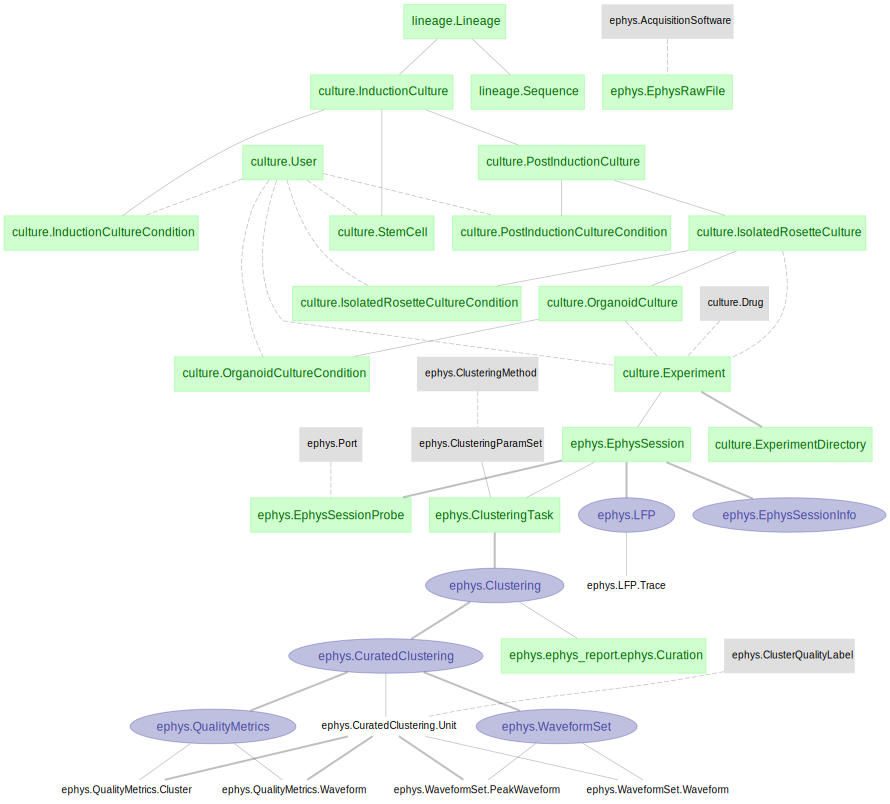

In [3]:
dj.Diagram(ephys) + dj.Diagram(culture) + dj.Diagram(lineage)

In [4]:
culture.OrganoidCulture()

lineage_id de-identified code (e.g. hmau001),induction_culture_date,induction_culture_plate,post_induction_culture_date,post_induction_culture_plate,isolated_rosette_culture_date Date for isolating the rosette,isolated_rosette_culture_plate,organoid_culture_date,organoid_culture_plate,isolated_rosette_culture_wells Wells from the 96-well plate used to embed organoids
hmau001,2023-10-12,6,2023-10-20,6,2023-10-12,1,2023-10-12,1,O13-16
hmau001,2023-10-12,6,2023-10-20,6,2023-10-12,1,2023-11-07,96,72
hmau004,2023-12-04,6,2023-12-11,6,2023-12-19,96,2023-12-19,96,1-24
hmau005,2023-12-04,6,2023-12-11,6,2023-12-19,96,2023-12-19,96,25-48
hmau006,2023-12-04,6,2023-12-11,6,2023-12-20,96,2023-12-19,96,49-72
hmau007,2023-12-04,6,2023-12-11,6,2023-12-20,96,2023-12-19,96,73-96
hmau008,2023-12-06,6,2023-12-13,6,2023-12-21,96,2024-02-22,96,1-24
hmau009,2023-12-06,6,2023-12-13,6,2023-12-21,96,2024-02-22,96,25-48
hmau010,2023-12-06,6,2023-12-13,6,2023-12-21,96,2024-02-22,96,49-65
hmau011,2023-12-06,6,2023-12-13,6,2023-12-21,96,2024-02-22,96,73-96


In [5]:
culture.Experiment & 'organoid_id="O09"'

organoid_id e.g. O17,experiment_start_time,experiment_end_time,user,lineage_id de-identified code (e.g. hmau001),induction_culture_date,induction_culture_plate,post_induction_culture_date,post_induction_culture_plate,isolated_rosette_culture_date Date for isolating the rosette,isolated_rosette_culture_plate,organoid_culture_date,organoid_culture_plate,drug_name,drug_concentration concentration in uM,"experiment_plan e.g. mrna lysate, oct, protein lysate, or matrigel embedding, ephys, tracing"
O09,2023-05-18 12:25:00,2023-05-18 18:15:00,None,None,None,None,None,None,None,None,None,None,4-AP,100.0,ephys
O09,2023-05-18 18:15:00,2023-05-19 09:30:00,None,None,None,None,None,None,None,None,None,None,No Drug,nan,ephys
O09,2023-05-19 09:30:00,2023-05-19 15:35:00,None,None,None,None,None,None,None,None,None,None,Bicuculline,50.0,ephys
O09,2023-05-19 15:45:00,2023-05-20 15:40:00,None,None,None,None,None,None,None,None,None,None,Tetrodotoxin,1.0,ephys


In [6]:
key = {
    "organoid_id": "O13",
    "experiment_start_time": datetime.datetime(2023, 6, 8, 19, 5),
    "insertion_number": 0,
    "start_time": datetime.datetime(2023, 6, 8, 19, 31),
    "end_time": datetime.datetime(2023, 6, 8, 19, 36),
    "paramset_idx": 1,
}

In [58]:
# (ephys.EphysSessionInfo & key).fetch1("session_info")

We will perform a query based on the parameter set associated with the latest version of SpikeInterface (`paramset_idx=1`):


In [8]:
ephys.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,spykingcircus2,Default parameters for spyking circus2 using SpikeInterface v0.100.1,b6fb9ec2-768c-66b0-2b71-9b8ac91e94da,=BLOB=
1,spykingcircus2,Default parameter set for spyking circus2 using SpikeInterface v0.101.*,434894d0-eb7b-db6c-80e6-638a1322c568,=BLOB=
2,kilosort2,kilosort2 with SpikeInterface version 0.101+,79a731f3-f1b6-c110-5f8a-e25227464de7,=BLOB=


In [9]:
key = {
    "organoid_id": "O13",
    "experiment_start_time": datetime.datetime(2023, 6, 8, 19, 5),
    "insertion_number": 0,
    "start_time": datetime.datetime(2023, 6, 8, 19, 31),
    "end_time": datetime.datetime(2023, 6, 8, 19, 36),
    "paramset_idx": 1,
}

In [10]:
ephys.QualityMetrics.Cluster() & key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,0,23.8267,2.74079,1.0,0.530396,271,3.65071e-05,133.659,0.010096,4.98496,0.9575,0.0255,0.252255,0.0,0.0,1.0
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,1,16.53,2.26264,1.0,0.00406642,1,0.00015163,189.752,0.0373887,4.10509,0.944,0.074,0.24834,0.0,0.0,0.00611834
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,2,22.0667,2.86574,1.0,0.538513,236,0.000182022,124.187,0.011351,4.84096,0.9615,0.0265,0.253988,0.0,0.0,1.0
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,3,33.89,2.78807,1.0,0.440175,455,0.000103441,44.6142,0.0354421,5.08914,0.92,0.00325,0.220742,0.0,0.0,0.644442
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,4,14.3933,1.99949,1.0,0.0268167,5,0.000458395,110.995,0.0234525,4.33129,0.9655,0.07,0.263887,0.0,0.0,0.0244335
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,5,35.4167,3.02021,1.0,0.532374,601,0.000135513,44.6992,0.0608578,3.88699,0.8965,0.0035,0.159265,0.0,0.0,1.0
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,6,22.6367,2.78969,1.0,0.581122,268,0.000516571,51.6958,0.0304479,5.28472,0.881,0.00225,0.194011,0.0,0.0,1.0
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,7,33.9767,2.93615,1.0,0.519744,540,5.01137e-05,127.028,0.00352815,5.24929,0.978,0.034,0.288597,0.0,0.0,1.0
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,8,31.8567,2.80082,1.0,0.60874,556,0.000200617,51.4923,0.0333564,5.07613,0.898,0.00275,0.214767,0.0,0.0,1.0
O13,2023-06-08 19:05:00,0,2023-06-08 19:31:00,2023-06-08 19:36:00,1,9,25.3467,2.99705,1.0,1.10341,638,6.87227e-05,95.937,0.0123779,4.91706,0.967,0.031,0.268466,0.0,0.0,1.0


These task keys will serve as examples to illustrate this notebook:


In [11]:
key_1 = {
    "organoid_id": "O09",
    "experiment_start_time": datetime.datetime(2023, 5, 18, 12, 25),
    "insertion_number": 0,
    "start_time": datetime.datetime(2023, 5, 18, 12, 52),
    "end_time": datetime.datetime(2023, 5, 18, 12, 57),
    "paramset_idx": 1,
}

In [12]:
key_2 = {
    "organoid_id": "O10",
    "experiment_start_time": datetime.datetime(2023, 5, 18, 12, 25),
    "insertion_number": 0,
    "start_time": datetime.datetime(2023, 5, 18, 12, 54),
    "end_time": datetime.datetime(2023, 5, 18, 12, 59),
    "paramset_idx": 1,
}

In [13]:
key_3 = {
    "organoid_id": "O11",
    "experiment_start_time": datetime.datetime(2023, 5, 18, 12, 25),
    "insertion_number": 0,
    "start_time": datetime.datetime(2023, 5, 18, 12, 25),
    "end_time": datetime.datetime(2023, 5, 18, 12, 30),
    "paramset_idx": 1,
}

## 2. Basic information on spike-sorted units can be found in `ephys.CuratedClustering.Unit` table


In [14]:
ephys.CuratedClustering.Unit & key_1

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,electrode_config_hash,probe_type e.g. A1x32-6mm-100-177-H32_21mm,"electrode electrode index, starts at 0","cluster_quality_label cluster quality type - e.g. 'good', 'MUA', 'noise', etc.",spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,0,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,16,n.a.,692,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,1,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,29,n.a.,10009,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,2,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,23,n.a.,10497,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,3,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,21,n.a.,7884,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,4,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,30,n.a.,9770,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,5,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,19,n.a.,11268,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,6,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,8,n.a.,7773,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,7,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,6,n.a.,10883,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,8,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,15,n.a.,9754,=BLOB=,=BLOB=,=BLOB=
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,9,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,27,n.a.,9275,=BLOB=,=BLOB=,=BLOB=


## 3. Examine and plot unit waveforms and correlograms


In [15]:
ephys.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,spykingcircus2,Default parameters for spyking circus2 using SpikeInterface v0.100.1,b6fb9ec2-768c-66b0-2b71-9b8ac91e94da,=BLOB=
1,spykingcircus2,Default parameter set for spyking circus2 using SpikeInterface v0.101.*,434894d0-eb7b-db6c-80e6-638a1322c568,=BLOB=
2,kilosort2,kilosort2 with SpikeInterface version 0.101+,79a731f3-f1b6-c110-5f8a-e25227464de7,=BLOB=


In [16]:
ephys.ClusteringMethod()

clustering_method,clustering_method_desc
combinato,
hdsort,
herdingspikes,
ironclust,
kilosort,
kilosort2,
kilosort2.5,
kilosort3,
kilosort4,
klusta,


In [17]:
ephys.WaveformSet & key_1

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1


In [18]:
ephys.WaveformSet.PeakWaveform * ephys.CuratedClustering.Unit & key_2

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,peak_electrode_waveform (uV) mean waveform for a given unit at its representative electrode,electrode_config_hash,probe_type e.g. A1x32-6mm-100-177-H32_21mm,"electrode electrode index, starts at 0","cluster_quality_label cluster quality type - e.g. 'good', 'MUA', 'noise', etc.",spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,0,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,4,n.a.,17747,=BLOB=,=BLOB=,=BLOB=
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,1,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,10,n.a.,14441,=BLOB=,=BLOB=,=BLOB=
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,2,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,12,n.a.,43055,=BLOB=,=BLOB=,=BLOB=
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,3,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,14,n.a.,18757,=BLOB=,=BLOB=,=BLOB=
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,4,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,0,n.a.,17105,=BLOB=,=BLOB=,=BLOB=
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,5,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,1,n.a.,18852,=BLOB=,=BLOB=,=BLOB=
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,6,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,6,n.a.,17373,=BLOB=,=BLOB=,=BLOB=
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,7,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,8,n.a.,16048,=BLOB=,=BLOB=,=BLOB=
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,8,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,7,n.a.,17993,=BLOB=,=BLOB=,=BLOB=
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,9,=BLOB=,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,15,n.a.,16956,=BLOB=,=BLOB=,=BLOB=


For this specific clustering task key `key_1` there are 35 units. Let's represent the mean waveforms for one unit and for all the units:


### 3.1. Plot waveform and correlogram for one specific unit


In [19]:
# Get waveform for unit = 1
unit = 1

(ephys.WaveformSet.PeakWaveform & key_1 & f"unit={unit}").fetch1(
    "peak_electrode_waveform"
)

array([  4.02050877,   4.3835988 ,   4.751369  ,   4.65309   ,
         4.17378044,   4.07471991,   4.60745907,   4.73615789,
         4.05833912,   3.14222956,   2.18595004,   1.1661005 ,
         0.13805997,  -0.58187997,  -1.69727874,  -3.72099113,
        -5.58752871,  -6.81759071,  -8.59209156, -11.7538147 ,
       -13.84188557, -12.46050453,  -8.7488718 ,  -5.9829874 ,
        -4.7689209 ,  -3.52911067,  -1.71560991,  -0.23985006,
         0.9987902 ,   2.16956902,   3.13208914,   3.26780987,
         3.37856793,   3.99359965,   4.71899796,   4.73459959,
         4.43546867,   4.57703972,   4.66049767,   4.26426029,
         3.57434964,   3.57591033,   3.63830829,   3.00924134,
         2.35677075,   2.01044869,   1.70741892,   1.05533969,
         0.41105995,   0.10139995,  -0.18095995,  -0.64154989,
        -1.20353997,  -1.36032045,  -1.36382949,  -1.32054019,
        -1.27295995,  -1.56545949,  -1.69104075,  -1.38996089])

In [20]:
# Plot the waveform and auto-correlogram
from element_array_ephys.plotting.unit_level import (
    plot_auto_correlogram,
    plot_waveform,
)

sampling_rate = (ephys.EphysSessionInfo & key_1).fetch1("session_info")[
    "sample_rate"
] / 1e3  # in kHz

peak_electrode_waveform, spike_times, cluster_quality_label = (
    (ephys.CuratedClustering.Unit & key_1 & f"unit={unit}")
    * ephys.WaveformSet.PeakWaveform
).fetch1("peak_electrode_waveform", "spike_times", "cluster_quality_label")

# Get the figure
waveform_fig = plot_waveform(
    waveform=peak_electrode_waveform, sampling_rate=sampling_rate
)

correlogram_fig = plot_auto_correlogram(
    spike_times=spike_times, bin_size=0.001, window_size=1
)

display(waveform_fig)
display(correlogram_fig)

### 3.2 Plot mean waveforms for all the units


#### For `key_1`


In [21]:
peak_wfs = (ephys.WaveformSet.PeakWaveform & key_1).fetch("peak_electrode_waveform")
sample_rate = (ephys.EphysSessionInfo & key_1).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

Plot the overlay of all the detected signals:


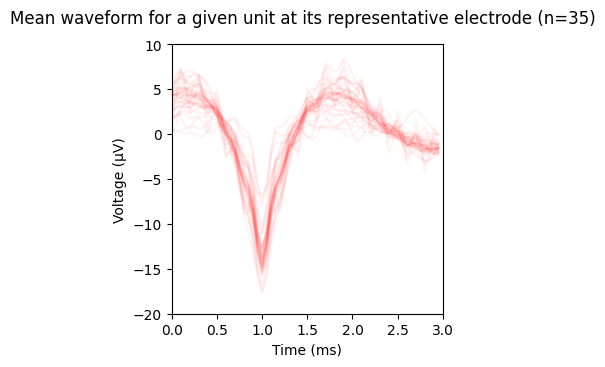

In [22]:
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.05)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(peak_wfs)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

#### For `key_2`


In [23]:
peak_wfs = (ephys.WaveformSet.PeakWaveform & key_2).fetch("peak_electrode_waveform")
sample_rate = (ephys.EphysSessionInfo & key_2).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

Plot the overlay of all the detected signals:


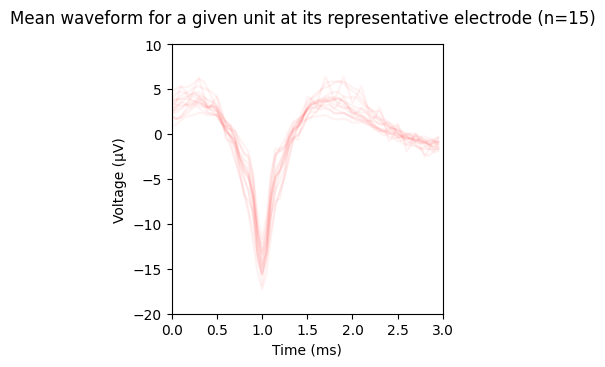

In [24]:
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.05)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(peak_wfs)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

#### For `key_3`


In [25]:
peak_wfs = (ephys.WaveformSet.PeakWaveform & key_3).fetch("peak_electrode_waveform")
sample_rate = (ephys.EphysSessionInfo & key_3).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

Plot the overlay of all the detected signals:


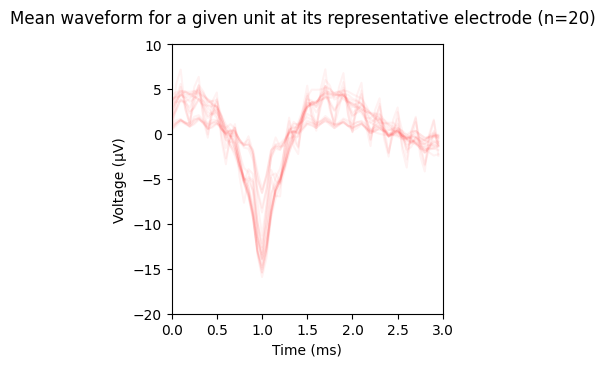

In [26]:
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.05)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(peak_wfs)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

## 4. Examine and plot `Cluster` Quality Metrics


### 4.1 Examine `QualityMetrics.Cluster`


In [27]:
ephys.QualityMetrics & key_1

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1


In [28]:
ephys.QualityMetrics.Cluster & key_1

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,0,2.30667,1.2885,0.2,10.6502,51,0.000973378,12.449,1.64799,1.29422,0.2805,0.10925,0.0222725,nan,nan,1.0
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,1,33.3633,2.3939,1.0,0.529047,530,0.00348457,37.2572,0.0871587,4.49079,0.861,0.005,0.183148,0.0,0.0,1.0
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,2,34.99,2.34152,1.0,0.430178,474,0.0055664,34.9269,0.129357,4.32139,0.837,0.00625,0.182643,0.0,0.0,0.75924
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,3,26.28,2.43663,1.0,0.440816,274,0.000128012,40.0324,0.10139,4.29865,0.8455,0.00725,0.177694,0.0,0.0,0.687825
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,4,32.5667,2.54148,1.0,0.490294,468,0.00016529,40.0109,0.084482,4.52959,0.8575,0.003,0.193257,0.0,0.0,0.748182
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,5,37.56,2.30099,1.0,0.345757,439,0.0188273,39.6281,0.0794419,4.4497,0.877,0.0045,0.198326,0.0,0.0,0.520702
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,6,25.91,2.59274,1.0,0.514734,311,0.000657147,49.4647,0.0382585,4.85431,0.877,0.00525,0.187222,0.0,0.0,0.637956
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,7,36.2767,2.25256,1.0,0.390916,463,0.00227223,119.78,0.0130779,4.78618,0.9525,0.045,0.253457,0.0,0.0,0.542043
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,8,32.5133,2.42762,1.0,0.442503,421,0.000315298,41.165,0.084976,4.57834,0.8585,0.004,0.18959,0.0,0.0,0.686669
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,9,30.9167,2.44056,1.0,0.512638,441,0.000349729,95.8882,0.0181679,4.51755,0.9485,0.0425,0.256099,0.0,0.0,1.0


In [29]:
query_1 = ephys.QualityMetrics.Cluster & key_1
query_2 = ephys.QualityMetrics.Cluster & key_2
query_3 = ephys.QualityMetrics.Cluster & key_3

In [30]:
query_1.heading

# Cluster metrics for a particular unit
organoid_id          : varchar(4)                   # e.g. O17
experiment_start_time : datetime                     # 
insertion_number     : tinyint unsigned             # 
start_time           : datetime                     # 
end_time             : datetime                     # 
paramset_idx         : smallint                     # 
unit                 : int                          # 
---
firing_rate=null     : float                        # (Hz) firing rate for a unit
snr=null             : float                        # signal-to-noise ratio for a unit
presence_ratio=null  : float                        # fraction of time in which spikes are present
isi_violation=null   : float                        # rate of ISI violation as a fraction of overall rate
number_violation=null : int                          # total number of ISI violations
amplitude_cutoff=null : float                        # estimate of miss rate based on amplitude histog

### 4.2 Plot histograms of cluster quality metrics


In [31]:
def plot_metric(
    ax,
    data,
    bins,
    x_axis_label=None,
    title=None,
    color="k",
    smoothing=True,
    density=False,
):
    """A function modified from https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html"""
    from scipy.ndimage import gaussian_filter1d

    if any(data) and np.nansum(data):
        h, b = np.histogram(data, bins=bins, density=density)
        x = b[:-1]

        y = gaussian_filter1d(h, 1) if smoothing else h
        ax.plot(x, y, color=color)
        ax.set_xlabel(x_axis_label)
        ax.set_ylim([0, None])
    ax.set_title(title)
    ax.spines[["right", "top"]].set_visible(False)

In [32]:
def plot_histograms(key, query):
    fig, axes = plt.subplots(4, 4, figsize=(25, 10))
    axes = axes.flatten()
    plt.suptitle(f"Cluster Quality Metrics for {key}", y=0.99, fontsize=14)

    # Firing Rates
    data = np.log10(query_1.fetch("firing_rate"))
    bins = np.linspace(-3, 6, 100)  # from 0.001 Hz to 100 Hz.
    plot_metric(axes[0], data, bins, title="Firing Rate (Hz) (log$_{10}$)")
    axes[0].set_ylabel("Count")

    # Signal-to-Noise Ratio
    data = query.fetch("snr")
    bins = np.linspace(0, 10, 100)  # signal quality: the better the higher
    plot_metric(axes[1], data, bins, title="Signal-to-Noise Ratio")

    # Presence Ratio
    data = query.fetch("presence_ratio")
    bins = np.linspace(
        0, 1, 100
    )  # a high presence (1) may indicate strong and consistent signal, neuron active
    plot_metric(
        axes[2],
        data,
        bins,
        title="Presence Ratio",
    )

    # ISI Violation
    data = query.fetch("isi_violation")
    bins = np.linspace(
        0, 1, 100
    )  # proportion of spikes that occur within a certain short interval (violating the refractory period of a neuron). High value may suggest presence of noise. For neural recordings, a lower ISI Violation ratio is usually preferred because it indicates higher quality data where detected spikes are less likely to be false positives.
    plot_metric(
        axes[3],
        data,
        bins,
        title="ISI Violation",
    )

    # Number Violation
    data = query.fetch("number_violation")
    bins = np.linspace(
        0, 10000, 100
    )  # close to 1000 poor spike sorting or high noise levels.
    plot_metric(
        axes[4],
        data,
        bins,
        title="Number Violation",
    )
    axes[4].set_ylabel("Count")

    # Amplitude Cutoff
    data = query.fetch("amplitude_cutoff")
    bins = np.linspace(
        0, 0.5, 100
    )  # higher value suggests potential issues with spike detection, such as noise or missed spikes.
    plot_metric(
        axes[5],
        data,
        bins,
        title="Amplitude Cutoff",
    )

    # Isolation Distance
    data = query.fetch("isolation_distance")
    bins = np.linspace(
        0, 170, 50
    )  # higher value suggests detected spikes are well-separated from noise and other neurons, implying high-quality spike sorting.
    plot_metric(
        axes[6],
        data,
        bins,
        title="Isolation Distance",
    )

    # L-Ratio
    data = query.fetch("l_ratio")
    bins = np.linspace(
        0, 1, 100
    )  # lower value indicates better separation between clusters of spikes.
    plot_metric(axes[7], data, bins, title="L-Ratio")

    # d-Prime
    data = query.fetch("d_prime")
    bins = np.linspace(
        0, 15, 50
    )  # measure used in signal detection theory to quantify the ability of an observer to distinguish between signal and noise. Higher values indicate better separation between clusters of spikes.
    plot_metric(axes[8], data, bins, title="d-Prime")
    axes[8].set_ylabel("Count")

    # Nearest-Neighbors Hit Rate
    data = query.fetch("nn_hit_rate")
    bins = np.linspace(
        0, 1, 100
    )  # A higher Nearest-Neighbors Hit Rate indicates better clustering or classification performance
    plot_metric(
        axes[9],
        data,
        bins,
        title="Nearest-Neighbors Hit Rate",
    )

    # Nearest-Neighbors Miss Rate
    data = query.fetch("nn_miss_rate")
    bins = np.linspace(
        0, 1, 100
    )  # a lower Nearest-Neighbors Miss Rate indicates better clustering or classification performance, as it suggests that the nearest neighbors tend to belong to the same class or cluster.
    plot_metric(
        axes[10],
        data,
        bins,
        title="Nearest-Neighbors Miss Rate",
    )

    # Silhouette Score
    data = query.fetch("silhouette_score")
    bins = np.linspace(
        -1, 1, 100
    )  # It measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
    plot_metric(axes[11], data, bins, title="Silhouette Score")

    # Max Drift
    data = query.fetch("max_drift")
    bins = np.linspace(
        0, 100, 100
    )  # It measures the amount of movement or displacement of the recording electrode during the experiment. A high value may indicate that the electrode was not stable during the recording session.
    plot_metric(
        axes[12],
        data,
        bins,
        title="Max Drift",
    )
    axes[12].set_ylabel("Count")

    # Cumulative Drift
    data = query.fetch("cumulative_drift")
    bins = np.linspace(
        0, 100, 100
    )  # total movement or displacement of the recording electrode throughout the experiment duration
    plot_metric(
        axes[13],
        data,
        bins,
        title="Cumulative drift",
    )

    # Contamination Rate
    data = query.fetch("contamination_rate")
    bins = np.linspace(
        0, 1, 100
    )  # percentage of data points in a cluster that are not members of that cluster. A high contamination rate may indicate that the cluster contains a significant number of spikes from other neurons.
    plot_metric(axes[14], data, bins, title="Contamination Rate")

    [ax.remove() for ax in axes[15:]]
    plt.tight_layout()

In [33]:
def plot_metric(
    ax,
    data,
    bins,
    x_axis_label=None,
    title=None,
    color="k",
    density=False,
):
    """A function modified from https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html"""
    if any(data) and np.nansum(data):
        h, b = np.histogram(data, bins=bins, density=density)
        width = np.diff(b)
        center = (b[:-1] + b[1:]) / 2
        ax.bar(center, h, align="center", width=width, color=color, alpha=0.7)
        ax.set_xlabel(x_axis_label)
        ax.set_ylim([0, None])
    ax.set_title(title)
    ax.spines[["right", "top"]].set_visible(False)

In [34]:
def plot_histograms(key, query):
    fig, axes = plt.subplots(4, 4, figsize=(25, 10))
    axes = axes.flatten()
    plt.suptitle(f"Cluster Quality Metrics for {key}", y=0.99, fontsize=14)

    # # Firing Rates
    # data = np.log10(query.fetch("firing_rate"))
    # bins = np.linspace(-3, 2, 100)  # from 0.001 Hz to 100 Hz.
    # plot_metric(axes[0], data, bins, title="Firing Rate (Hz) (log$_{10}$)")
    # axes[0].set_ylabel("Count")
    # axes[0].set_xlabel("Count")

    # Firing Rates
    data = query.fetch("firing_rate")
    bins = np.logspace(-3, 2, 50)  # from 0.001 Hz to 100 Hz
    log_data = np.log10(data)
    log_bins = np.log10(bins)

    plot_metric(
        axes[0], log_data, log_bins, title=f"Firing Rate (# of units: {len(query)})"
    )
    axes[0].set_ylabel("# of units")
    axes[0].set_ylim(0, 20)
    tick_positions = np.log10([0.1, 1, 10, 100])
    tick_labels = ["0.1", "1", "10", "100"]
    axes[0].set_xticks(tick_positions)
    axes[0].set_xticklabels(tick_labels)
    axes[0].set_xlabel("Hz")

    # Signal-to-Noise Ratio
    data = query.fetch("snr")
    bins = np.linspace(0, 10, 100)  # signal quality: the better the higher
    plot_metric(axes[1], data, bins, title="Signal-to-Noise Ratio")
    axes[1].set_ylabel("# of units")
    axes[1].set_xlabel("SNR")

    # Presence Ratio
    data = query.fetch("presence_ratio")
    bins = np.linspace(
        0, 1, 100
    )  # a high presence (1) may indicate strong and consistent signal, neuron active
    plot_metric(
        axes[2],
        data,
        bins,
        title="Presence Ratio",
    )

    # ISI Violation
    data = query.fetch("isi_violation")
    bins = np.linspace(
        0, 1, 100
    )  # proportion of spikes that occur within a certain short interval (violating the refractory period of a neuron). High value may suggest presence of noise. For neural recordings, a lower ISI Violation ratio is usually preferred because it indicates higher quality data where detected spikes are less likely to be false positives.
    plot_metric(
        axes[3],
        data,
        bins,
        title="ISI Violation",
    )

    # Number Violation
    data = query.fetch("number_violation")
    bins = np.linspace(
        0, 10000, 100
    )  # close to 1000 poor spike sorting or high noise levels.
    plot_metric(
        axes[4],
        data,
        bins,
        title="Number Violation",
    )
    axes[4].set_ylabel("Count")

    # Amplitude Cutoff
    data = query.fetch("amplitude_cutoff")
    bins = np.linspace(
        0, 0.5, 100
    )  # higher value suggests potential issues with spike detection, such as noise or missed spikes.
    plot_metric(
        axes[5],
        data,
        bins,
        title="Amplitude Cutoff",
    )

    # Isolation Distance
    data = query.fetch("isolation_distance")
    bins = np.linspace(
        0, 170, 50
    )  # higher value suggests detected spikes are well-separated from noise and other neurons, implying high-quality spike sorting.
    plot_metric(
        axes[6],
        data,
        bins,
        title="Isolation Distance",
    )

    # L-Ratio
    data = query.fetch("l_ratio")
    bins = np.linspace(
        0, 1, 100
    )  # lower value indicates better separation between clusters of spikes.
    plot_metric(axes[7], data, bins, title="L-Ratio")

    # d-Prime
    data = query.fetch("d_prime")
    bins = np.linspace(
        0, 15, 50
    )  # measure used in signal detection theory to quantify the ability of an observer to distinguish between signal and noise. Higher values indicate better separation between clusters of spikes.
    plot_metric(axes[8], data, bins, title="d-Prime")
    axes[8].set_ylabel("Count")

    # Nearest-Neighbors Hit Rate
    data = query.fetch("nn_hit_rate")
    bins = np.linspace(
        0, 1, 100
    )  # A higher Nearest-Neighbors Hit Rate indicates better clustering or classification performance
    plot_metric(
        axes[9],
        data,
        bins,
        title="Nearest-Neighbors Hit Rate",
    )

    # Nearest-Neighbors Miss Rate
    data = query.fetch("nn_miss_rate")
    bins = np.linspace(
        0, 1, 100
    )  # a lower Nearest-Neighbors Miss Rate indicates better clustering or classification performance, as it suggests that the nearest neighbors tend to belong to the same class or cluster.
    plot_metric(
        axes[10],
        data,
        bins,
        title="Nearest-Neighbors Miss Rate",
    )

    # Silhouette Score
    data = query.fetch("silhouette_score")
    bins = np.linspace(
        -1, 1, 100
    )  # It measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
    plot_metric(axes[11], data, bins, title="Silhouette Score")

    # Max Drift
    data = query.fetch("max_drift")
    bins = np.linspace(
        0, 100, 100
    )  # It measures the amount of movement or displacement of the recording electrode during the experiment. A high value may indicate that the electrode was not stable during the recording session.
    plot_metric(
        axes[12],
        data,
        bins,
        title="Max Drift",
    )
    axes[12].set_ylabel("Count")

    # Cumulative Drift
    data = query.fetch("cumulative_drift")
    bins = np.linspace(
        0, 100, 100
    )  # total movement or displacement of the recording electrode throughout the experiment duration
    plot_metric(
        axes[13],
        data,
        bins,
        title="Cumulative drift",
    )

    # Contamination Rate
    data = query.fetch("contamination_rate")
    bins = np.linspace(
        0, 1, 100
    )  # percentage of data points in a cluster that are not members of that cluster. A high contamination rate may indicate that the cluster contains a significant number of spikes from other neurons.
    plot_metric(axes[14], data, bins, title="Contamination Rate")

    [ax.remove() for ax in axes[15:]]
    plt.tight_layout()

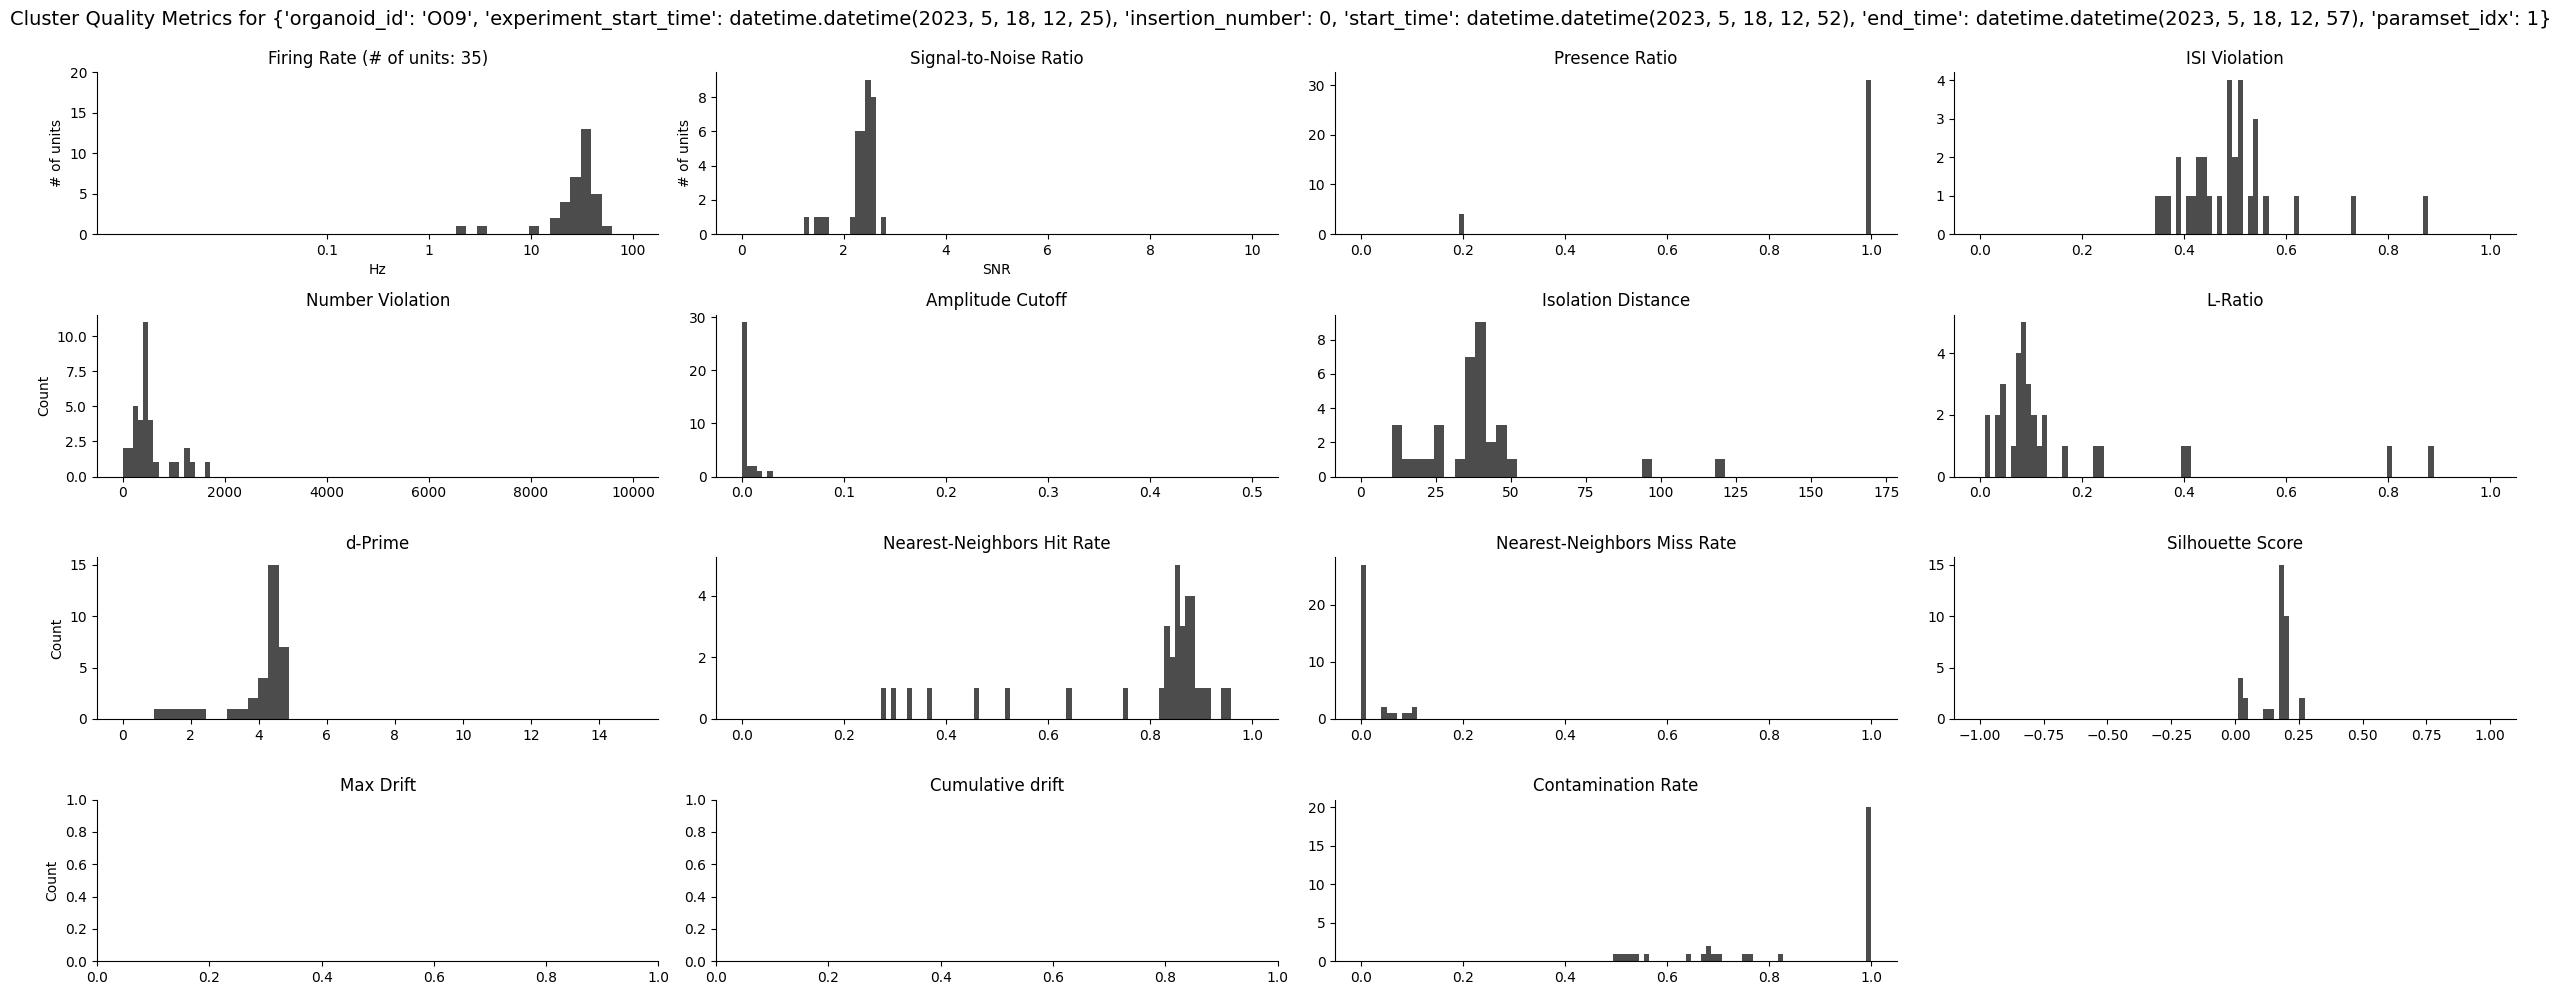

In [35]:
plot_histograms(key_1, query_1)

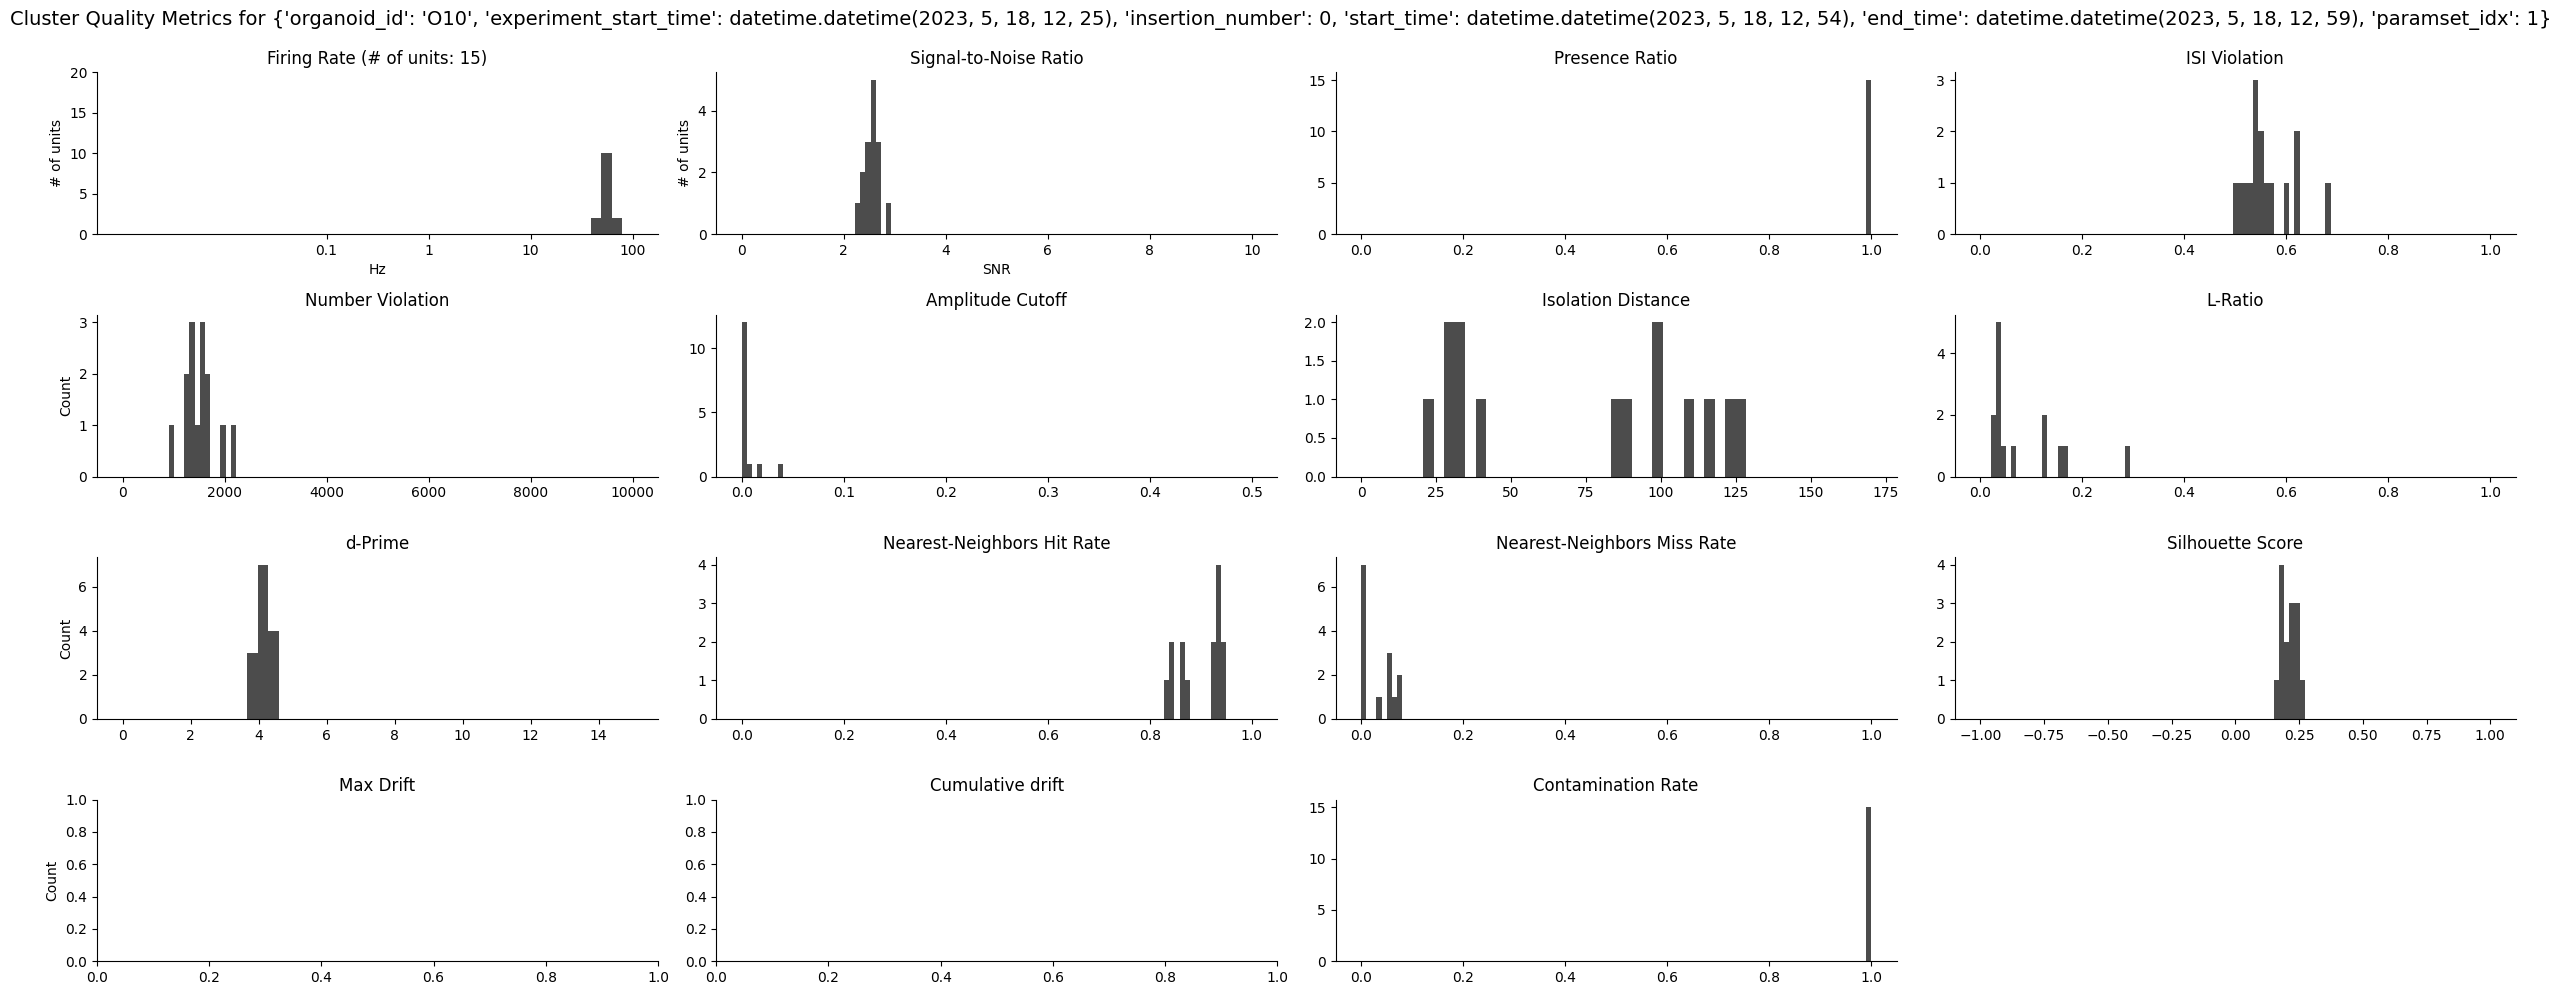

In [36]:
plot_histograms(key_2, query_2)

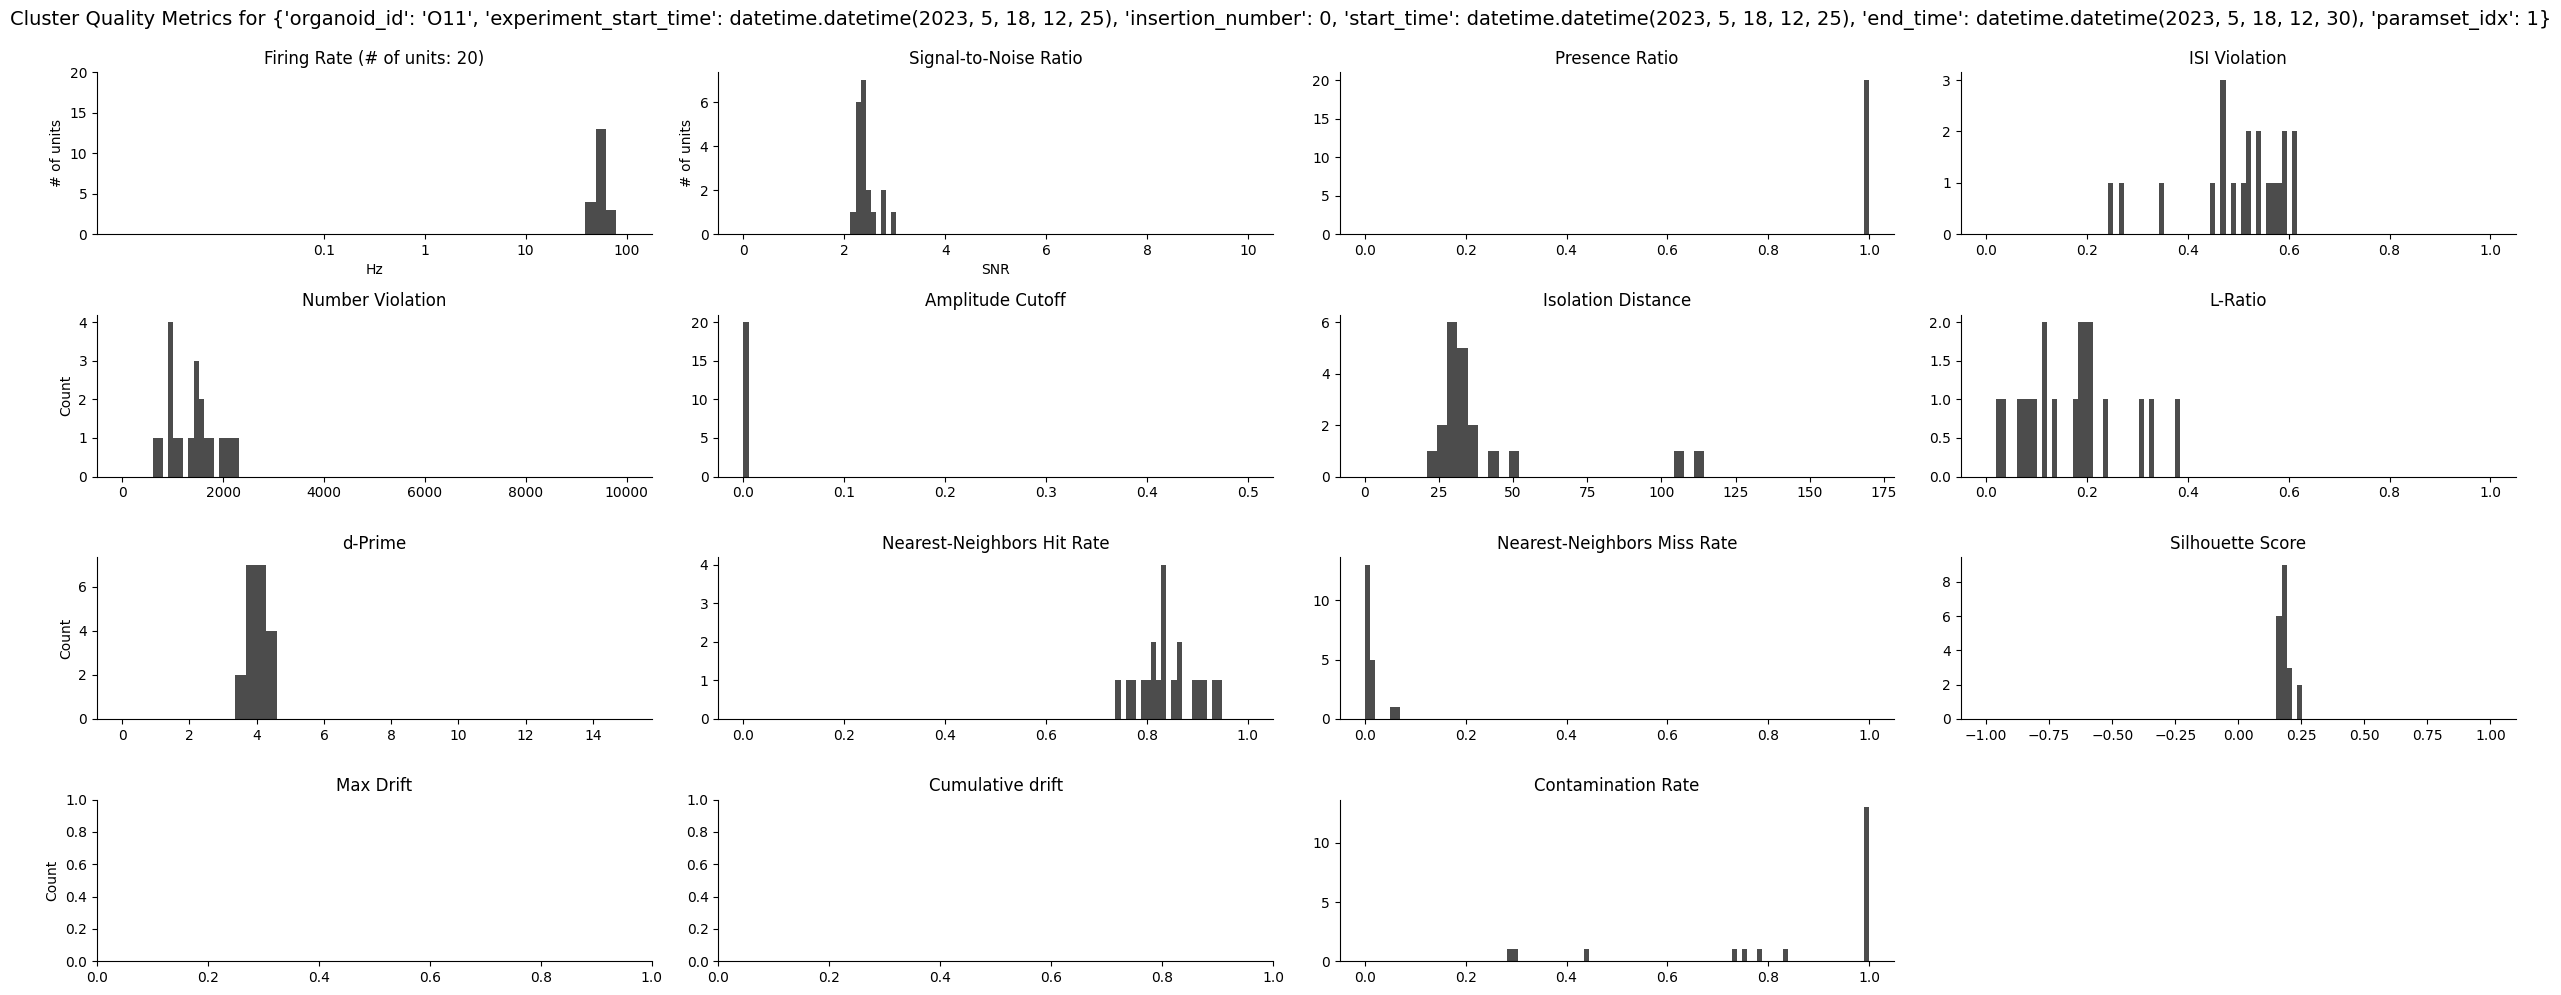

In [37]:
plot_histograms(key_3, query_3)

### 4.3 Filtering by Cluster Quality Metrics


#### For `key_1`


In [38]:
len(ephys.QualityMetrics.Cluster & key_1)

35

In [39]:
len(
    ephys.QualityMetrics.Cluster
    & key_1
    & "presence_ratio > 0.9"
    & "isi_violation < 0.5"
    & "isolation_distance > 25"
    & "l_ratio < 0.2"
    & "silhouette_score > 0.1"
)

19

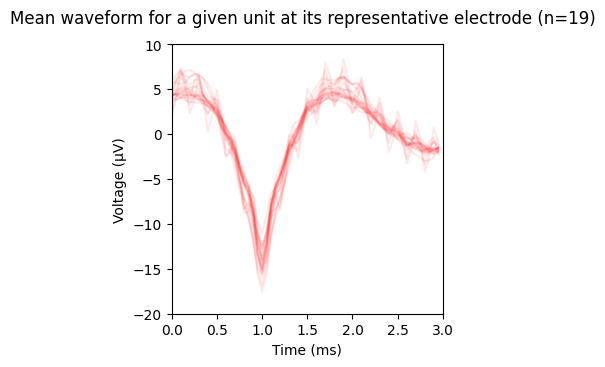

In [40]:
filtered_key = (
    ephys.QualityMetrics.Cluster
    & key_1
    & "presence_ratio > 0.9"
    & "isi_violation < 0.5"
    & "isolation_distance > 25"
    & "l_ratio < 0.2"
    & "silhouette_score > 0.1"
).fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(filtered_key)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

#### For `key_2`


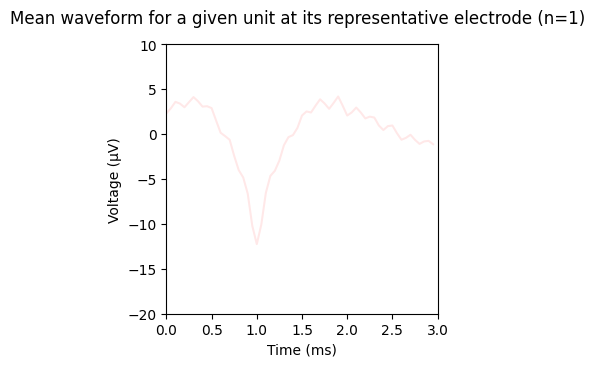

In [41]:
filtered_key = (
    ephys.QualityMetrics.Cluster
    & key_2
    & "presence_ratio > 0.9"
    & "isi_violation < 0.5"
    & "isolation_distance > 25"
    & "l_ratio < 0.2"
    & "silhouette_score > 0.1"
).fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(filtered_key)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

#### For `key_3`


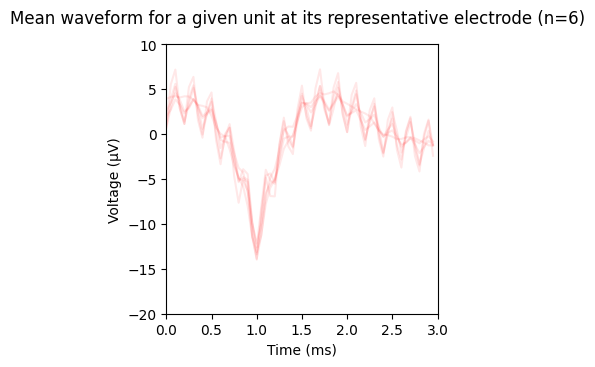

In [42]:
filtered_key = (
    ephys.QualityMetrics.Cluster
    & key_3
    & "presence_ratio > 0.9"
    & "isi_violation < 0.5"
    & "isolation_distance > 25"
    & "l_ratio < 0.2"
    & "silhouette_score > 0.1"
).fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(filtered_key)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

## 5 Examine and plot Waveform Quality Metrics


### 5.1 Examine `QualityMetrics.Waveform`


In [43]:
ephys.QualityMetrics.Waveform & key_1

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,0,-5.85,0.000685,0.000315,-0.411953,25892.7,1179.48,100.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,1,-13.845,0.00072,0.00028,-0.348707,40014.5,-6507.14,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,2,-14.82,0.000895,0.000425,-0.498894,33773.1,-10272.3,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,3,-12.48,0.00069,0.00029,-0.360042,36676.4,-4541.49,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,4,-14.04,0.00078,0.000245,-0.314915,41397.5,-5936.28,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,5,-14.625,0.0009,0.00045,-0.566018,37079.9,-9840.2,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,6,-13.26,0.000855,0.00017,-0.248068,43918.6,-5732.27,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,7,-11.31,0.000705,0.0004,-0.436306,25917.0,-5381.14,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,8,-13.65,0.000705,0.00023,-0.289083,46777.1,-5476.35,0.0,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:52:00,2023-05-18 12:57:00,1,9,-14.43,0.000785,0.000285,-0.377473,40888.1,-8110.63,0.0,nan,nan


In [44]:
wf_query_1 = ephys.QualityMetrics.Waveform & key_1
wf_query_2 = ephys.QualityMetrics.Waveform & key_2
wf_query_3 = ephys.QualityMetrics.Waveform & key_3

In [45]:
wf_query_1.heading

# Waveform metrics for a particular unit
organoid_id          : varchar(4)                   # e.g. O17
experiment_start_time : datetime                     # 
insertion_number     : tinyint unsigned             # 
start_time           : datetime                     # 
end_time             : datetime                     # 
paramset_idx         : smallint                     # 
unit                 : int                          # 
---
amplitude=null       : float                        # (uV) absolute difference between waveform peak and trough
duration=null        : float                        # (ms) time between waveform peak and trough
halfwidth=null       : float                        # (ms) spike width at half max amplitude
pt_ratio=null        : float                        # absolute amplitude of peak divided by absolute amplitude of trough relative to 0
repolarization_slope=null : float                        # the repolarization slope was defined by fitting a regression line

### 5.2. Plot histograms of waveform quality metrics


In [46]:
def plot_wf_histograms(key, wf_query):
    fig, axes = plt.subplots(3, 2, figsize=(25, 10))
    axes = axes.flatten()
    plt.suptitle(f"Waveform Quality Metrics for {key}", y=0.99, fontsize=14)

    # Amplitude
    data = wf_query.fetch("amplitude")
    bins = np.linspace(-30, 0, 50)
    plot_metric(axes[0], data, bins, title="Amplitude")
    axes[0].set_ylabel("Count")
    axes[0].set_xlabel("Amplitude (μV)")

    # Duration
    data = wf_query.fetch("duration") * 1e3  # s -> ms
    bins = np.linspace(0, 0.001, 50) * 1e3  # in s -> ms
    plot_metric(
        axes[1], data, bins, title="Duration: Time between waveform peak and trough "
    )
    axes[1].set_xlabel("Duration (ms)")

    # Spike Width at half max amplitude
    data = wf_query.fetch("halfwidth") * 1e3  # s -> ms
    bins = np.linspace(0, 0.001, 50) * 1e3  # in s -> ms
    plot_metric(
        axes[2],
        data,
        bins,
        title="Spike Width at half max amplitude",
    )
    axes[2].set_ylabel("Count")
    axes[2].set_xlabel("Duration (ms)")

    # PT Ratio
    data = wf_query.fetch("pt_ratio")
    bins = np.linspace(-1, 1, 50)
    plot_metric(
        axes[3],
        data,
        bins,
        title="Peak-Trough Ratio",  # A PT Ratio closer to 1 indicates that the peak and trough have similar amplitudes, suggesting a symmetric waveform. A PT Ratio significantly different from 1 indicates asymmetry in the waveform, with the peak or trough being more prominent.
    )

    # Repolarization Slope
    data = wf_query.fetch("repolarization_slope")
    bins = np.linspace(10e3, 100e3, 50)
    plot_metric(
        axes[4],
        data,
        bins,
        title="Repolarization Slope",
    )
    axes[4].set_ylabel("Count")

    # Spread
    data = wf_query.fetch("spread")
    bins = np.linspace(0, 250, 50)
    plot_metric(
        axes[5],
        data,
        bins,
        title="Spread",
    )
    axes[5].set_xlabel("Spread (μm)")

    plt.tight_layout()
    plt.show()

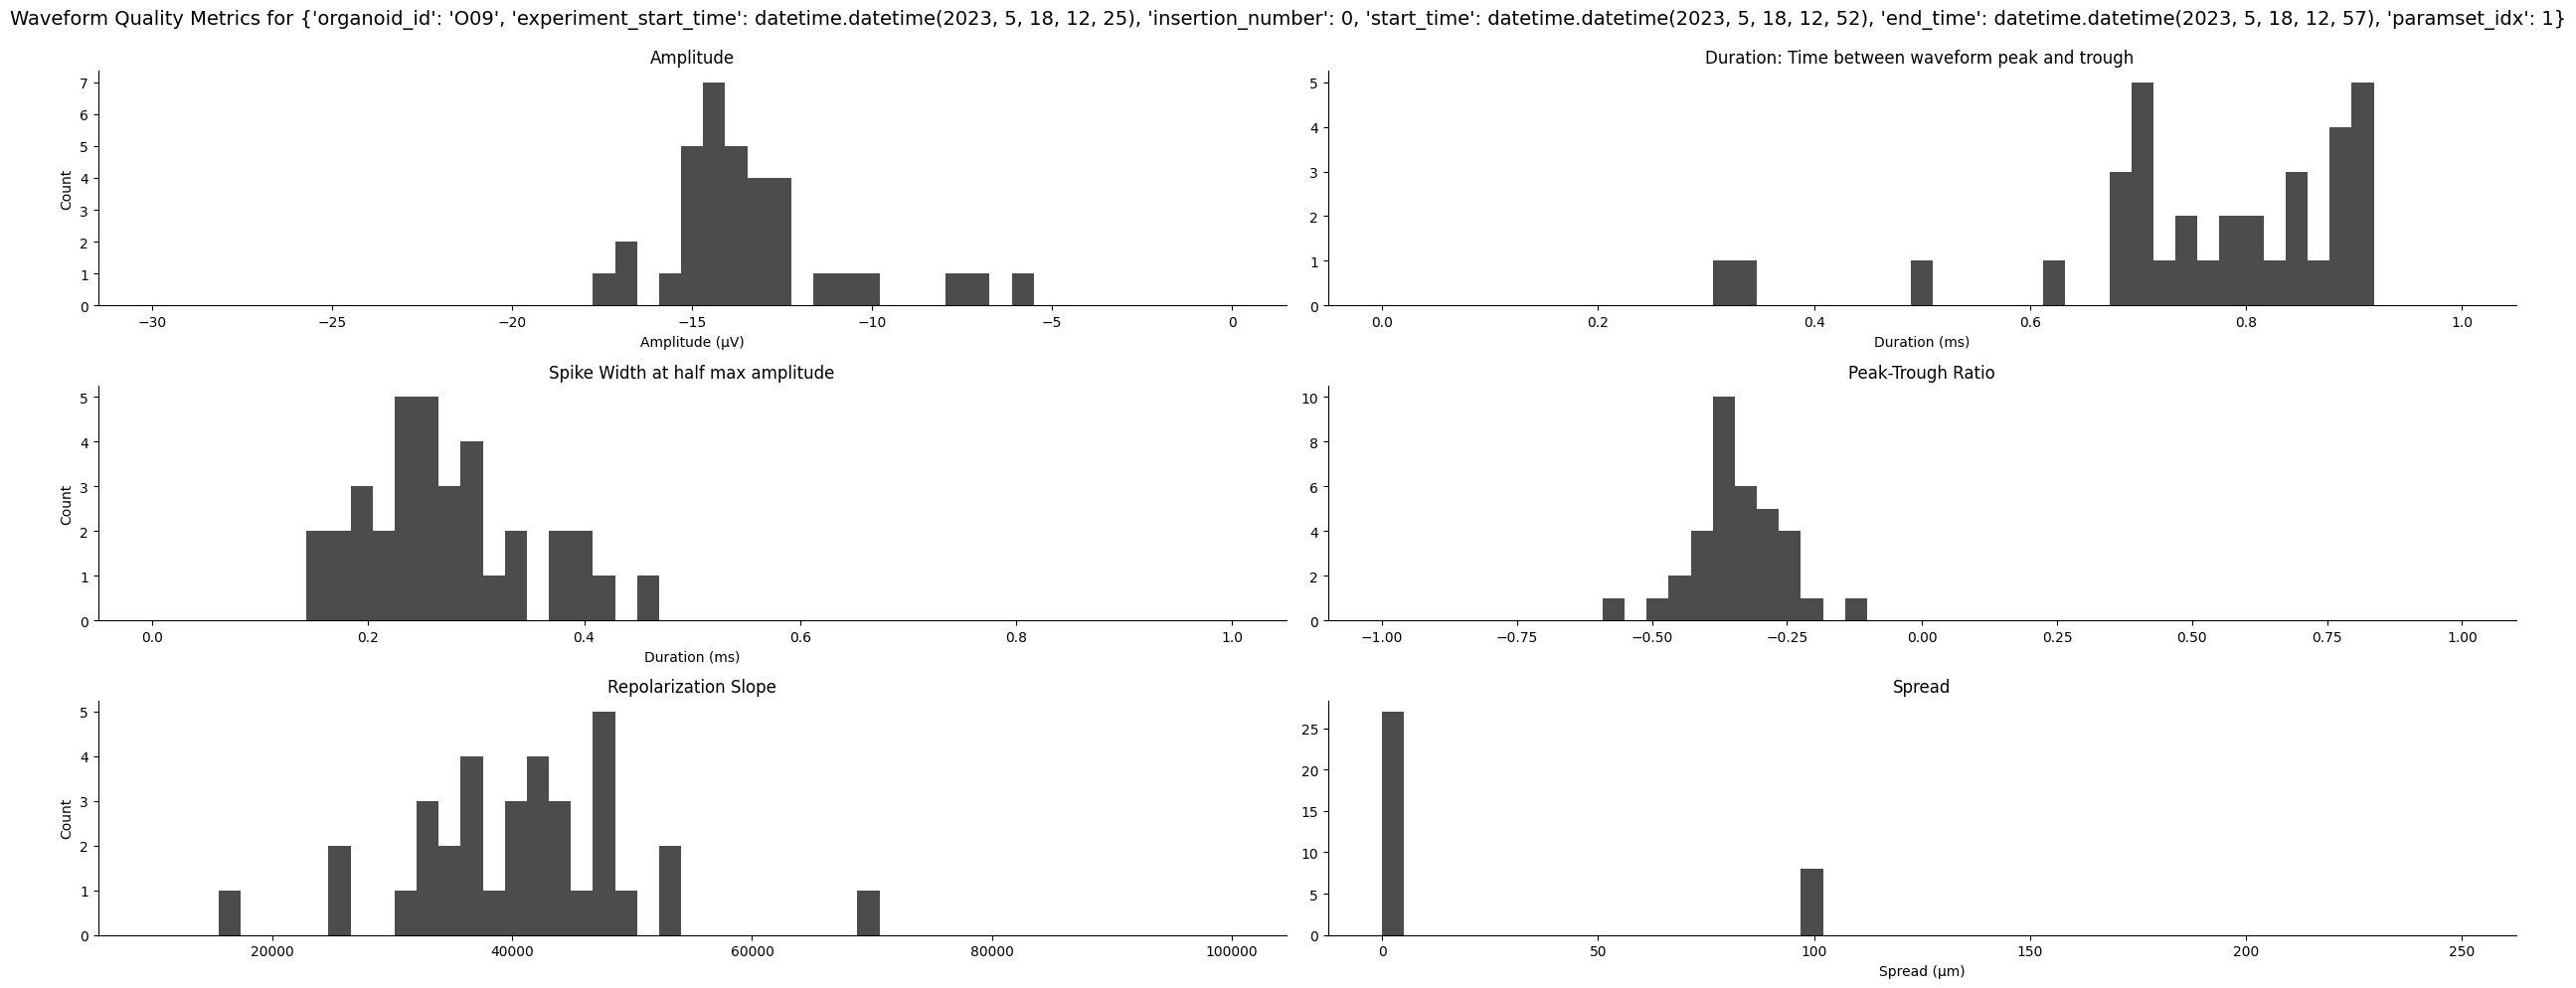

In [47]:
plot_wf_histograms(key_1, wf_query_1)

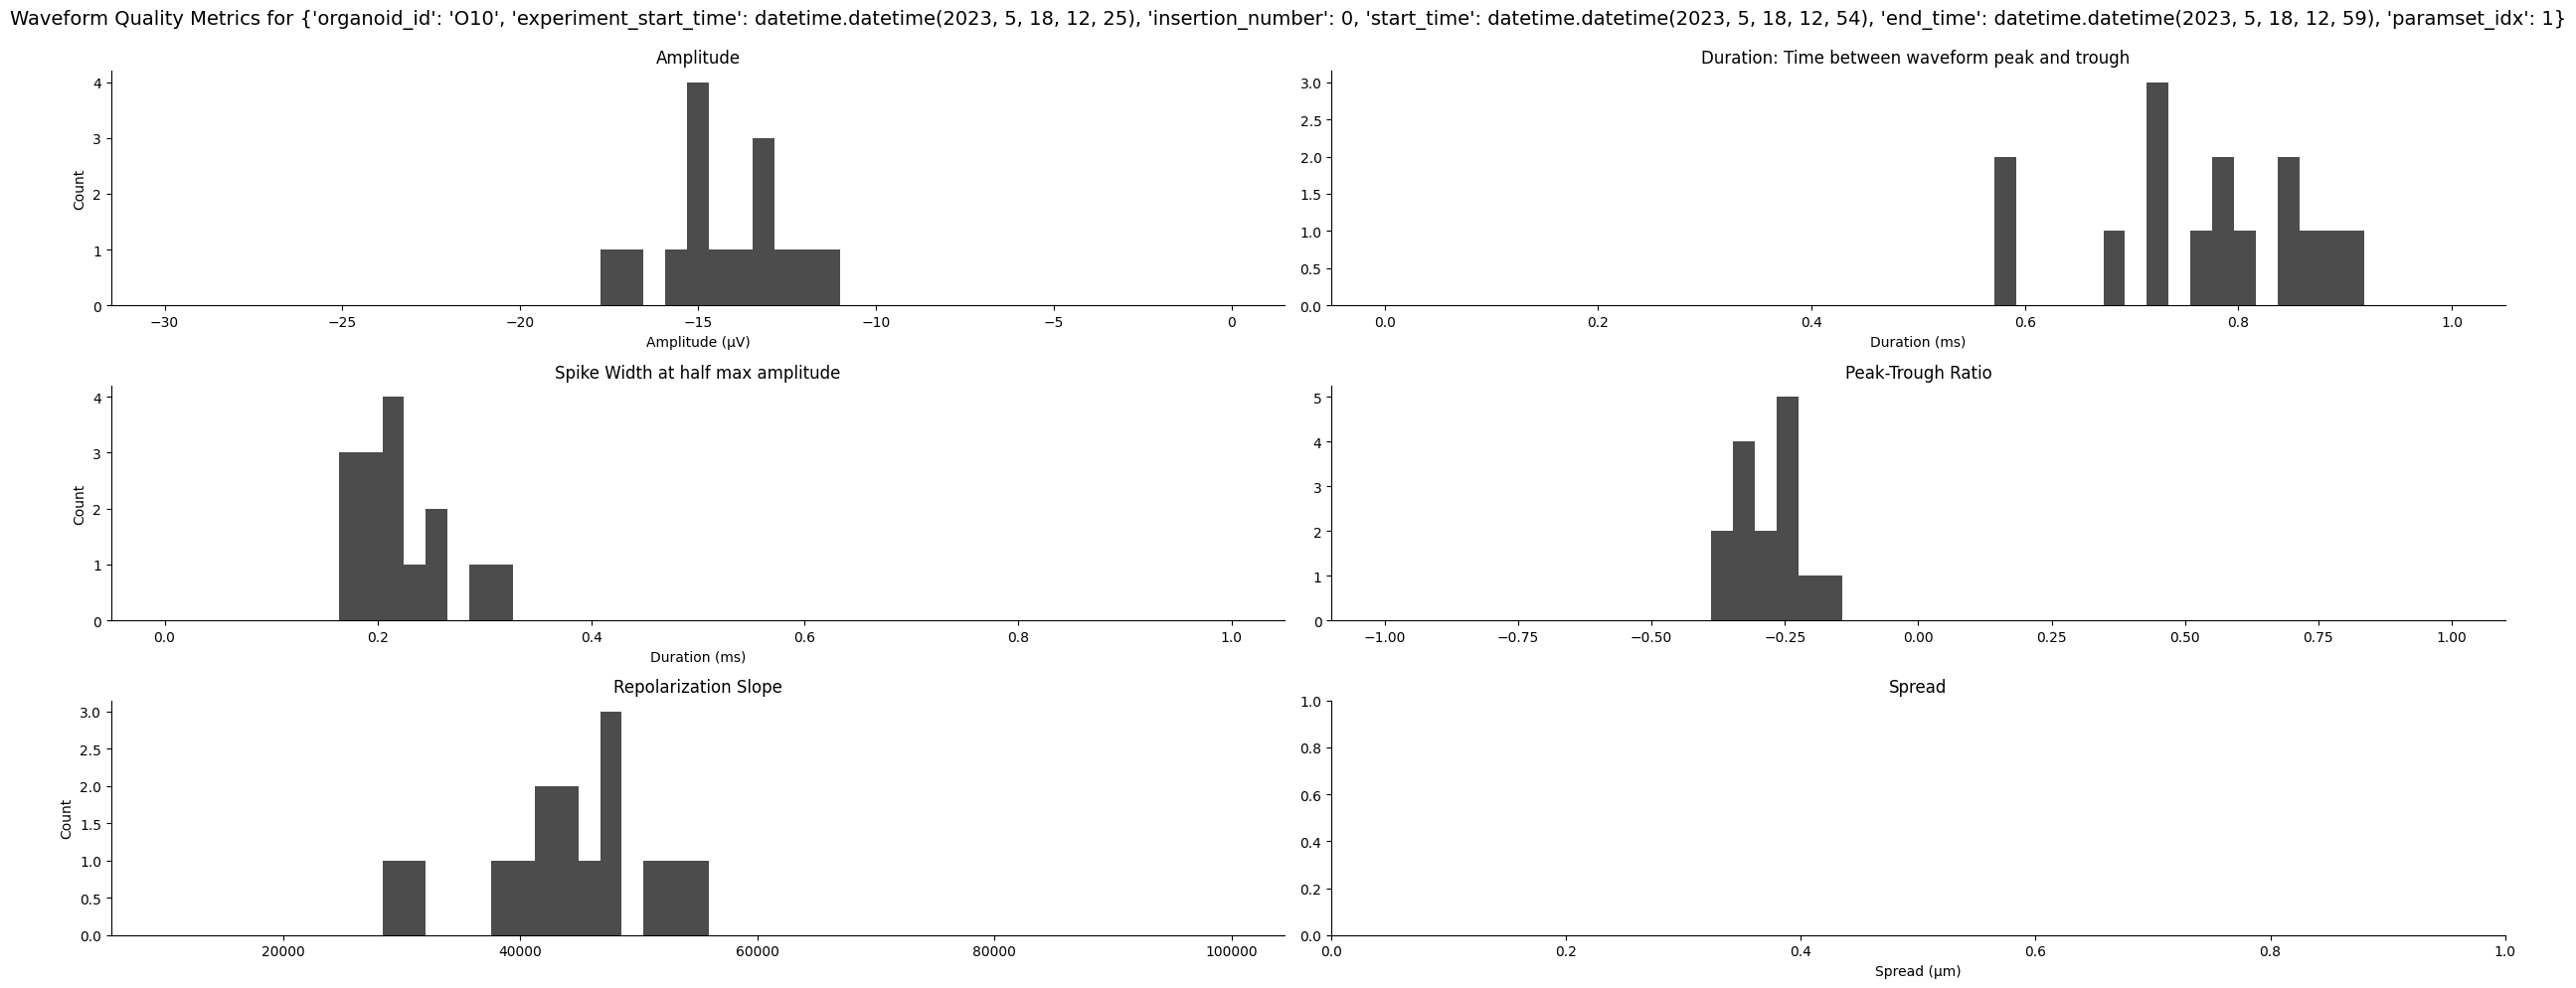

In [48]:
plot_wf_histograms(key_2, wf_query_2)

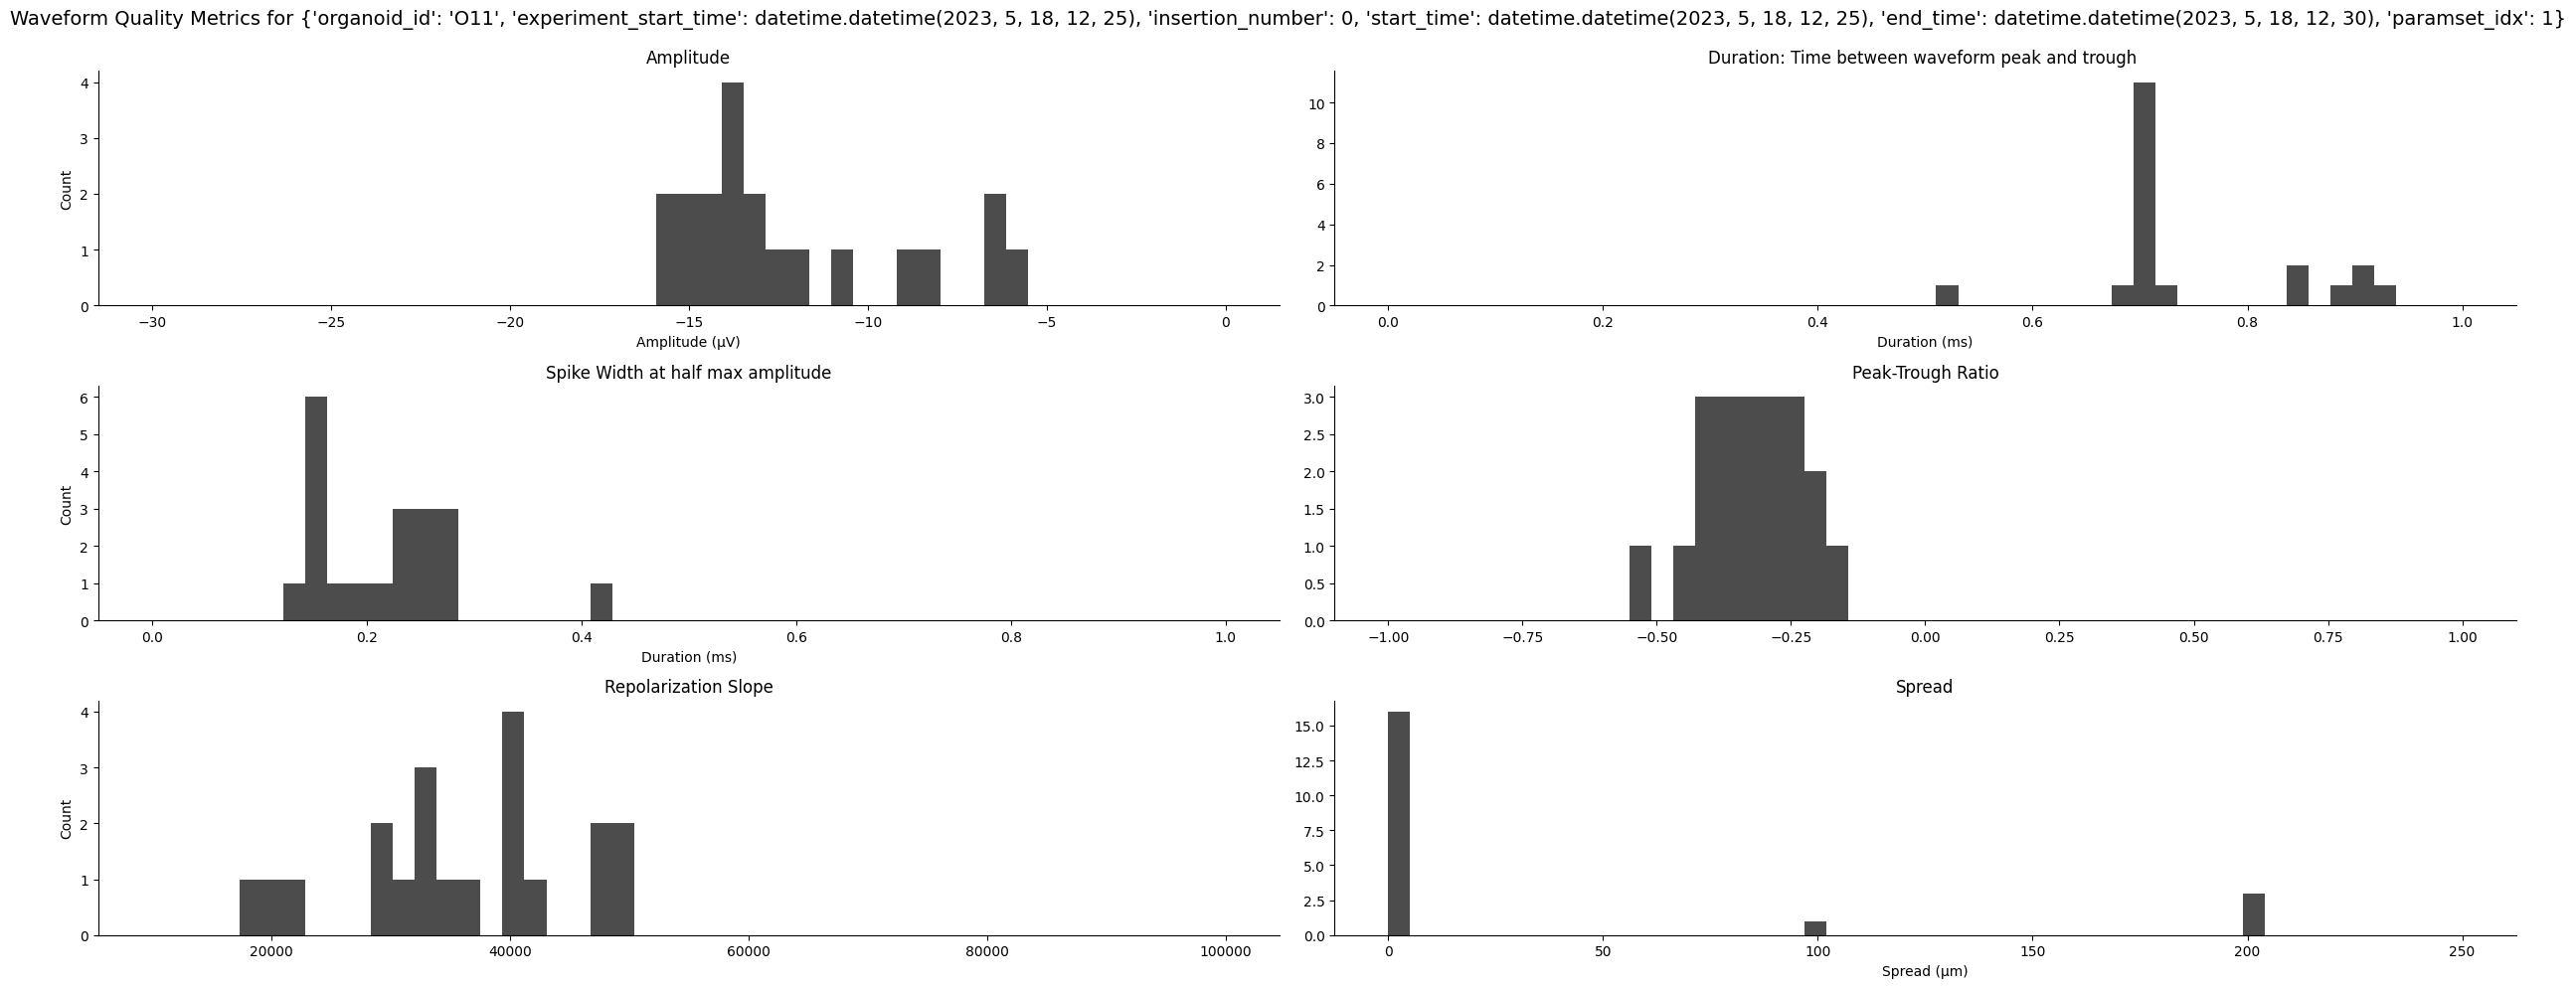

In [49]:
plot_wf_histograms(key_3, wf_query_3)

In [50]:
len(key_3)

6

### 5.3 Filtering by Waveform QMetrics


#### For `key_1`


In [52]:
len(ephys.QualityMetrics.Waveform & key_1)

35

In [53]:
len(
    ephys.QualityMetrics.Waveform
    & key_1
    & "amplitude > -20 < 20"  # -20 μV
    # & "halfwidth > 0.0002"  # 0.2 ms
    # & "duration > 0.0002"
    & "spread > 50"
    & "pt_ratio > -0.2"
)

2

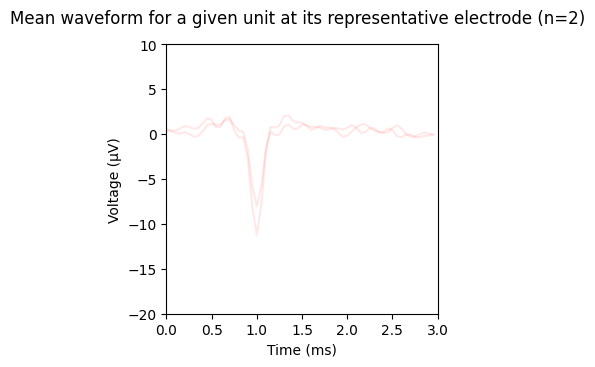

In [54]:
filtered_key = (
    ephys.QualityMetrics.Waveform
    & key_1
    & "amplitude > -20 < 20"  # -20 μV
    # & "halfwidth > 0.0002"  # 0.2 ms
    # & "duration > 0.0002"
    & "spread > 50"
    & "pt_ratio > -0.2"
).fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(filtered_key)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

#### For `key_2`


In [55]:
len(
    ephys.QualityMetrics.Waveform
    & key_2
    & "amplitude > -20 < 20"  # -20 μV
    # & "halfwidth > 0.0002"  # 0.2 ms
    # & "duration > 0.0002"
    # & "spread > 50"
    & "pt_ratio > -0.2"
)

1

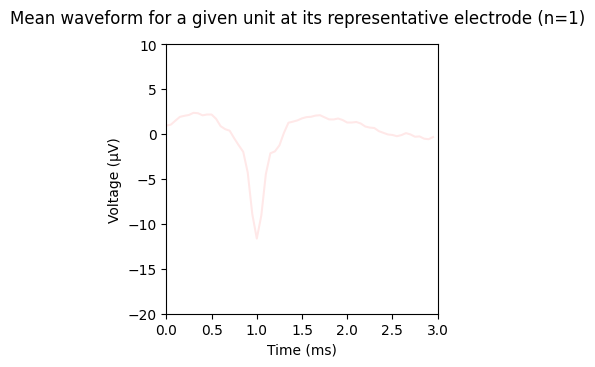

In [56]:
filtered_key = (
    ephys.QualityMetrics.Waveform
    & key_2
    & "amplitude > -20 < 20"  # -20 μV
    # & "halfwidth > 0.0002"  # 0.2 ms
    # & "duration > 0.0002"
    # & "spread > 50"
    & "pt_ratio > -0.2"
).fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(filtered_key)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

#### For `key_3`


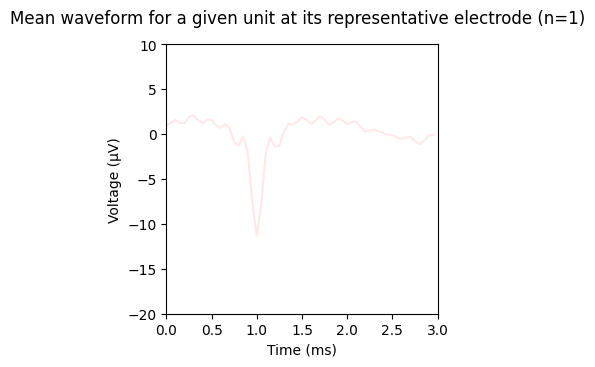

In [57]:
filtered_key = (
    ephys.QualityMetrics.Waveform
    & key_3
    & "amplitude > -20 < 20"  # -20 μV
    # & "halfwidth > 0.0002"  # 0.2 ms
    # & "duration > 0.0002"
    # & "spread > 50"
    & "pt_ratio > -0.2"
).fetch("KEY")
peak_wfs = (ephys.WaveformSet.PeakWaveform & filtered_key).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & filtered_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(filtered_key)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

## Download the spike-sorted data (SpikeInterface)


In [ ]:
key = key_1
key

In [ ]:
from workflow.utils.initiate_session import download_spike_sorted_results
from dotenv import load_dotenv

load_dotenv()
download_spike_sorted_results(key)